In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input

load_dotenv('../.env')

FILE_PATH = os.getenv("EP")

In [2]:
df = pd.read_csv(FILE_PATH, index_col='DATE', parse_dates=True)

In [3]:
df.columns = ['Production']

In [4]:
df.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


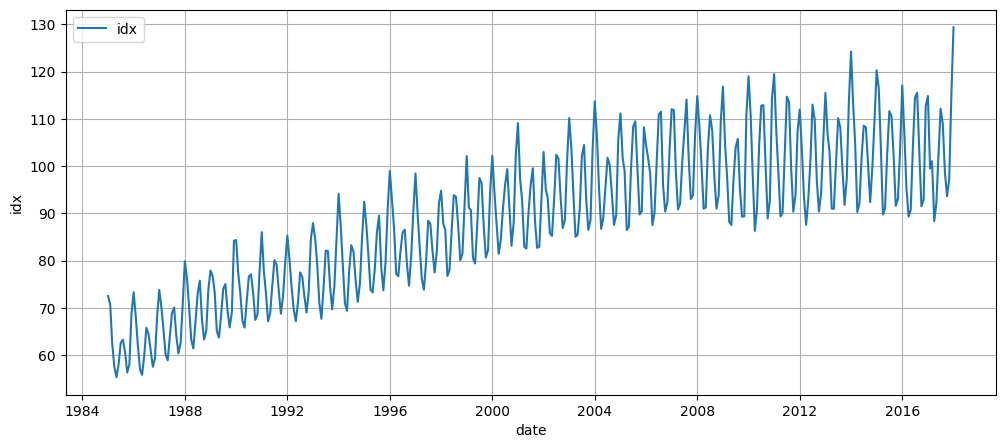

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Production'], label='idx')
plt.xlabel('date')
plt.ylabel('idx')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
decomposition = seasonal_decompose(df['Production'], model='additive', period=12)

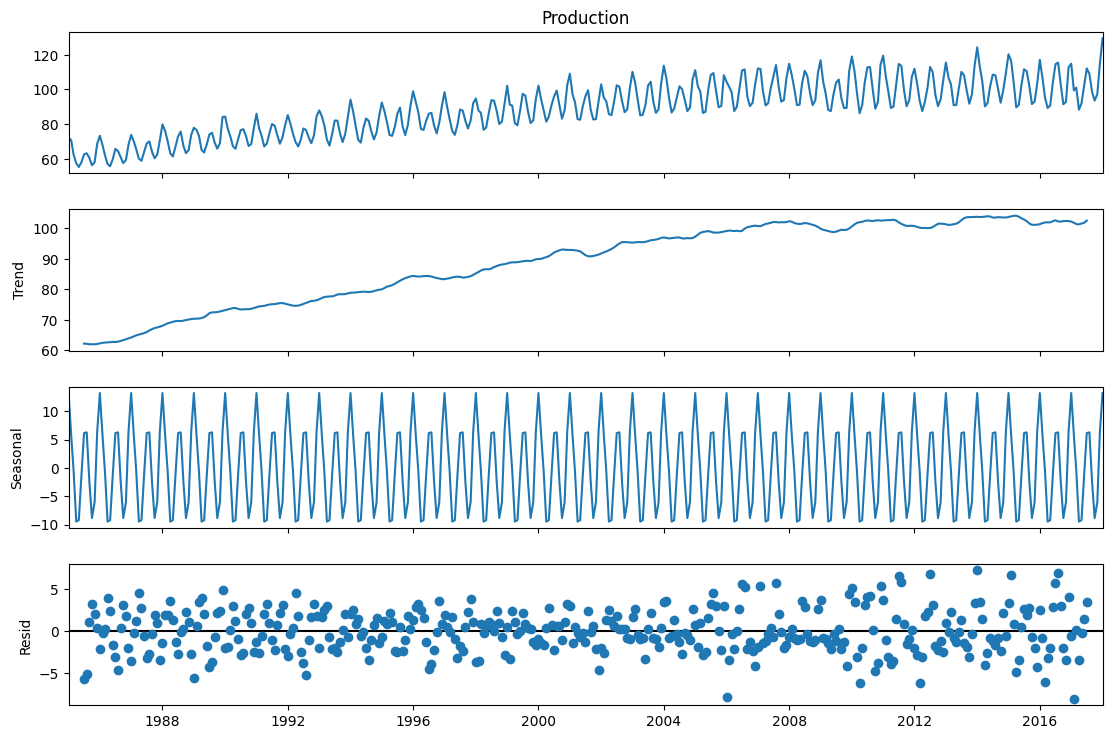

In [8]:
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [9]:
result = adfuller(df['Production'], autolag='AIC')
result[1]

0.18621469116586592

In [10]:
# Замечательно

In [11]:
df['Lag_1'] = df['Production'].shift(1)

In [12]:
df['Lag_12'] = df['Production'].shift(12)

In [13]:
df['Month'] = df.index.month

In [14]:
df['Year'] = df.index.year

In [15]:
df_clean = df.dropna()

In [16]:
df_clean.head(5)

,Production,Lag_1,Lag_12,Month,Year
DATE,,,,,
1986-01-01,73.3057,68.7145,72.5052,1,1986
1986-02-01,67.9869,73.3057,70.6720,2,1986
1986-03-01,62.2221,67.9869,62.4502,3,1986
1986-04-01,57.0329,62.2221,57.4714,4,1986
1986-05-01,55.8137,57.0329,55.3151,5,1986


In [17]:
data = df_clean['Production'].values.reshape(-1, 1)

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [19]:
TIME_STEP = 12

In [20]:
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [21]:
X, y = create_sequences(scaled_data, TIME_STEP)

In [22]:
split_point = len(X) - 24 
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [23]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
X_train.shape

(349, 12, 1)

In [25]:
X_test.shape

(24, 12, 1)

In [26]:
lstm_model = Sequential()

In [27]:
INPUT_SHAPE = (TIME_STEP, 1)

In [28]:
lstm_model.add(Input(shape=INPUT_SHAPE))
lstm_model.add(LSTM(
    units=100, 
    activation='relu'
))
lstm_model.add(Dense(units=1))

In [29]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history_lstm = lstm_model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=0
)

In [32]:
lstm_predictions = lstm_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [33]:
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [34]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, lstm_predictions_rescaled))

In [35]:
rmse_lstm

5.837325401203785

In [36]:
gru_model = Sequential()
gru_model.add(Input(shape=INPUT_SHAPE))
gru_model.add(GRU(
    units=100, 
    activation='relu'
))
gru_model.add(Dense(units=1))

In [37]:
gru_model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 100)                 │          30,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,001 (121.10 KB)

 Trainable params: 31,001 (121.10 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history_gru = gru_model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=0
)

In [40]:
gru_predictions = gru_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


In [41]:
gru_predictions_rescaled = scaler.inverse_transform(gru_predictions)

In [42]:
rmse_gru = np.sqrt(mean_squared_error(y_test_rescaled, gru_predictions_rescaled))

In [43]:
rmse_gru

5.262783789573198

In [44]:
test_index = df_clean.index[-len(y_test_rescaled):]

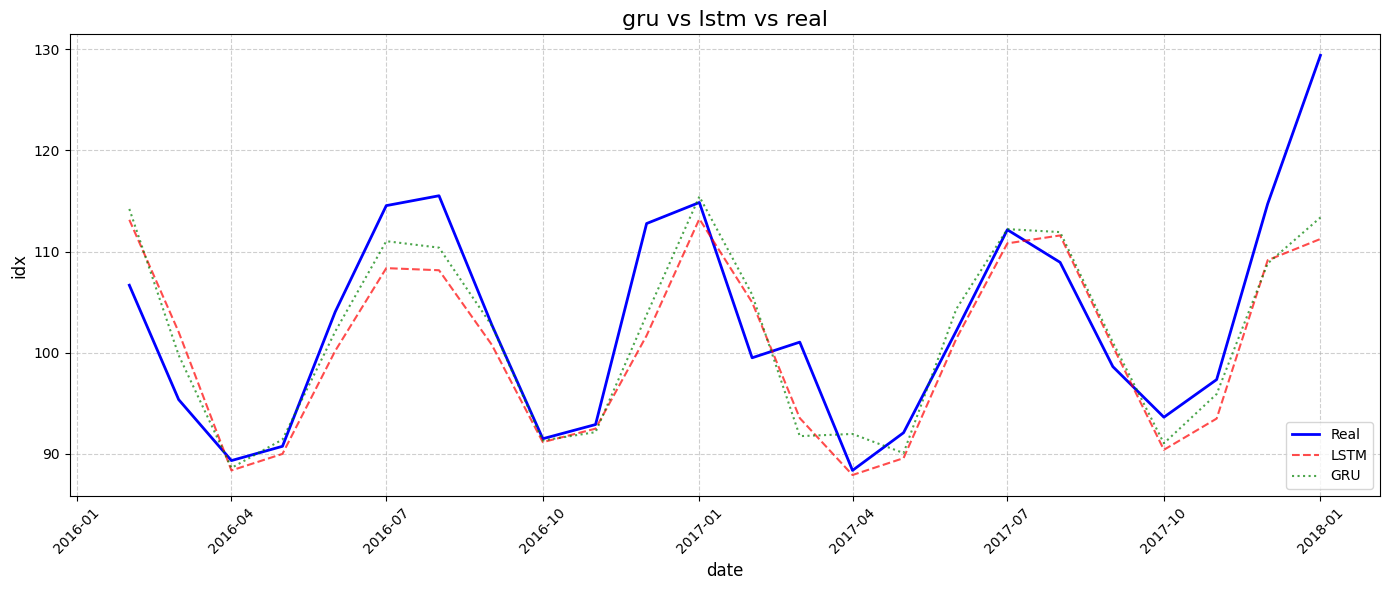

In [45]:
plt.figure(figsize=(14, 6))

plt.plot(test_index, y_test_rescaled, 
         label='Real', 
         color='blue', 
         linewidth=2)

plt.plot(test_index, lstm_predictions_rescaled, 
         label='LSTM', 
         color='red', 
         linestyle='--', 
         alpha=0.7)

plt.plot(test_index, gru_predictions_rescaled, 
         label='GRU', 
         color='green', 
         linestyle=':', 
         alpha=0.7)

plt.title('gru vs lstm vs real', fontsize=16)
plt.xlabel('date', fontsize=12)
plt.ylabel('idx', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# ну если визуально, то как будто GRU получше пики ловит, на низах почти не промахивается, rmse меньше